# GDVSpectra

## Initialise GDVSpectra

### Load packages

In [1]:
%matplotlib inline
%load_ext autoreload

import os, sys
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import datacube
sys.path.append('../../../Scripts')
from dea_datahandling import load_ard
from dea_dask import create_local_dask_cluster
from dea_plotting import display_map, rgb

sys.path.append('../../modules')
import gdvspectra

sys.path.append('../../shared')
import satfetcher, tools

/env/lib/python3.6/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


### Set up a dask cluster and ODC

In [2]:
# initialise the cluster. paste url into dask panel for more info.
create_local_dask_cluster()

# open up a datacube connection
dc = datacube.Datacube(app='gdvspectra')

Client Scheduler: tcp://127.0.0.1:39095 Dashboard: /user/lewis/proxy/8787/status,Cluster Workers: 1 Cores: 2 Memory: 13.11 GB


/env/lib/python3.6/site-packages/datacube/drivers/postgres/_connections.py:87: SADeprecationWarning: Calling URL() directly is deprecated and will be disabled in a future release.  The public constructor for URL is now the URL.create() method.
  username=username, password=password,


## Study area and data setup

### Set study area, time range, show map

In [3]:
# testing study area extent - yandi and roy hill
lat_extent, lon_extent = (-22.82901, -22.67901), (118.94980, 119.29979)  # yandi
#lat_extent, lon_extent = (-22.63461, -22.33461), (119.88111, 120.18111) # royhill

# display onto interacrive map
display_map(x=lon_extent, y=lat_extent)

### Load DEA ODC satellite data

In [4]:
# provide study area name
study_area = 'yandi'

# select start and end year range
time_range = ('2009', '2020')

# set datacube query parameters
platform = 'landsat'
bands = ['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2']
#bands = ['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir_1', 'nbart_swir_2'] # sentinel
min_gooddata = 0.90

# fetch satellite data from dea ard product
ds = satfetcher.load_dea_ard(platform=platform, 
                             bands=bands, 
                             x_extent=lon_extent, 
                             y_extent=lat_extent, 
                             time_range=time_range, 
                             min_gooddata=min_gooddata, 
                             use_dask=True)

# display dataset
#ds

/env/lib/python3.6/site-packages/datacube/drivers/postgres/_connections.py:87: SADeprecationWarning: Calling URL() directly is deprecated and will be disabled in a future release.  The public constructor for URL is now the URL.create() method.
  username=username, password=password,
/home/jovyan/tenement-tools/notebooks/gdvspectra/../../../Tools/dea_tools/datahandling.py:237: UserWarning: Setting 'min_gooddata' percentage to > 0.0 will cause dask arrays to compute when loading pixel-quality data to calculate 'good pixel' percentage. This can slow the return of your dataset.
  warnings.warn("Setting 'min_gooddata' percentage to > 0.0 "


Loading DEA ODC ARD satellite data.
Finding datasets
    ga_ls5t_ard_3
    ga_ls7e_ard_3
    ga_ls8c_ard_3
Counting good quality pixels for each time step
Filtering to 191 out of 468 time steps with at least 90.0% good quality pixels
Applying pixel quality/cloud mask
Returning 191 time steps as a dask array
Satellite imagery fetched successfully.


### Conform band names

In [5]:
# rename dea bands to common standard
ds = satfetcher.conform_dea_ard_band_names(ds=ds, platform=platform)

# display dataset
#ds

Conforming DEA ARD satellite band names.
Satellite band names conformed successfully.


### Make a copy of raw dataset

In [6]:
# take a copy of dataset for cva later
ds_backup = ds.copy(deep=True)

## Generate seasonal vegetation and moisture data

### Reduce to wet (jfm) and dry (son) season months

In [7]:
# set wet and dry season month(s). we will use several per season
wet_month, dry_month = [1, 2, 3], [9, 10, 11]

# get subset fo data for wet and dry season months
ds = gdvspectra.subset_months(ds=ds, 
                              month=wet_month + dry_month,
                              inplace=True)

# display dataset
#ds

Subsetting down to specified months.
Reducing dataset into months: [1, 2, 3, 9, 10, 11].
Subset to requested months successfully.


### Calculate vegetation and moisture indices

In [8]:
# calculate veg (mavi) and moist (ndmi) indices
ds = tools.calculate_indices(ds=ds, 
                             index=['mavi', 'ndmi'], 
                             custom_name=['veg_idx', 'mst_idx'], 
                             rescale=True, 
                             drop=True)

# display dataset
#ds

Calculating indices: ['mavi', 'ndmi'].
Calculating index: mavi
Calculating index: ndmi
Rescaled index values from -1 to 1 -> 0 to 2.
Renamed default indices.
Calculated indices successfully.


## Resample data

### Resample data to annual seasonal (djf and son) medians 

In [9]:
# perform resampling
ds = gdvspectra.resample_to_wet_dry_medians(ds=ds, 
                                            wet_month=wet_month, 
                                            dry_month=dry_month,
                                            inplace=True)

# display dataset
#ds

Resampling dataset to annual wet and dry medians.
Resampled dataset to annual wet and dry medians successfully.


### Persist memory

In [10]:
# we have some calcs to make, persist now
ds = ds.persist()

## Pre-process dataset (e.g., outlier removal, interpolation)

### Remove outliers via z-score

In [11]:
# check for outlier times and nullify whole image. warning: persists memory
ds = gdvspectra.nullify_wet_dry_outliers(ds=ds, 
                                         wet_month=wet_month, 
                                         dry_month=dry_month, 
                                         p_value=0.01,
                                         inplace=True)

# display dataset
#ds

Nullifying wet, dry season outliers usign Z-Score test.
No outlier dates detected.
Nullified wet, dry season outliers successfully.


### Remove any years missing wet, dry season data

In [12]:
# drop any years from dataset where wet and dry seasons missing
ds = gdvspectra.drop_incomplete_wet_dry_years(ds)

# display dataset
#ds

Dropping years where both wet, dry do not exist.
No uneven years detected, no data lost.


### Fill empty data edges via backward and/or forward fill

In [13]:
# ! WARNING ! this func requires pre-computed data due to xr-dask bfill and ffill bug
# xr-dask bfill/ffill will perform without error, but does not update values in ds
# todo - remove this compute when bug fixed in ver > 0.18.2
ds = ds.compute()

In [14]:
# fill any empty first, last years using back/forward fill
ds = gdvspectra.fill_empty_wet_dry_edges(ds=ds,
                                         wet_month=wet_month, 
                                         dry_month=dry_month,
                                         inplace=True)

# display dataset
#ds

Filling empty wet and dry edges in dataset.
Filling wet season edges.
First time has values. No need to fill.
Last time has values. No need to fill.
Filling dry season edges.
First time has values. No need to fill.
Last time has values. No need to fill.
Filled empty wet and dry edges successfully.


### Interpolate missing data

In [15]:
# interpolate all missing pixels using full linear interpolation
ds =  gdvspectra.interp_empty_wet_dry(ds=ds,
                                      wet_month=wet_month, 
                                      dry_month=dry_month,
                                      method='full', 
                                      inplace=True)

# display dataset
#ds

Interpolating empty values in dataset.
Interpolated empty values successfully.


## Standardise data

### Generate invariant targets and standardise

In [16]:
# standardise data to invariant targets derived from dry times
ds = gdvspectra.standardise_to_dry_targets(ds=ds, 
                                           dry_month=dry_month, 
                                           q_upper=0.99, 
                                           q_lower=0.05,
                                           inplace=True)

# display dataset
#ds

Standardising data using invariant targets.
Calculating invariant target sites.
Got orthogonal polynomial coefficients: [-11.  -9.  -7.  -5.  -3.  -1.   1.   3.   5.   7.   9.  11.]
Got sum of squares: 572 and constant 2: 
Created invariant target sites successfully.
Standardising to invariant targets, rescaling via fuzzy sigmoidal.
Standardised using invariant targets successfully.


## Calculate seasonal similarity

### Calculate seasonal similarity

In [17]:
# calculate standardised seaonal similarity (diff between wet, dry per year)
ds_similarity = gdvspectra.calc_seasonal_similarity(ds=ds,
                                                    wet_month=wet_month,
                                                    dry_month=dry_month,
                                                    q_mask=0.9,
                                                    inplace=True)

# display dataset
#ds

Calculating seasonal similarity.
Rescaling via increasing-decreasing sigmoidal.
Masking similarity areas to higher vege and moist areas.
Calculated seasonal similarity successfully.


## Perform GDV likelihood modelling

### Generate likelihood model

Generating groundwater-dependent vegetation (GDV) model.
Generated groundwater-dependent vegetation model successfully


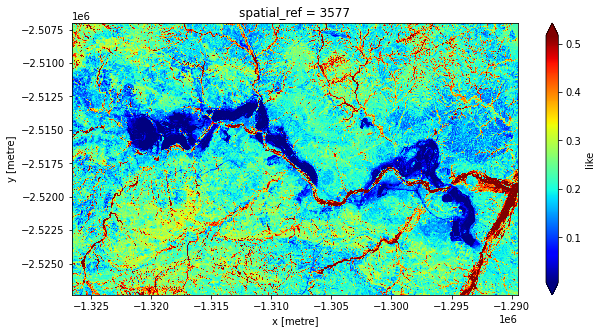

In [18]:
# generate gdv likelihood model using wet, dry, similarity variables
ds_like = gdvspectra.calc_likelihood(ds=ds, 
                                     ds_similarity=ds_similarity,
                                     wet_month=wet_month, 
                                     dry_month=dry_month)

# preview an all-time median of gdv likelihood. red is high likelihood
fig = plt.figure(figsize=(10, 5))
ds_like['like'].median('time').plot(robust=True, cmap='jet')

### Generate field occurrence points for thresholding

In [19]:
# set location of point shapefile with presence/absence column
#shp_path = r'../GDVSDM/data_testing/presence_points/presence_points.shp'
shp_path = r'../../data/gdvspectra/yandi_2_final_albers.shp'

# read shapefile as pandas dataframe
df_records = tools.read_shapefile(shp_path=shp_path)

# subset to just x, y, pres/abse column
df_records = tools.subset_records(df_records=df_records, p_a_column='GDV_ACT')

# display dataframe
#df_records

Reading records within shapefile.
Rows read from shapefile successfully.
Subsetting records from dataframe.
Subset records successfully.


### Threshold likelihood

Thresholding groundwater-dependent vegeation likelihood.
Thresholding dataset via occurrence records and AUC.
Clipping pandas dataframe records to xarray dataset.
Extracting cell resolution from dataset.
Resolution extracted successfully from dataset.
Extracted xarray dataset values successfully.
Removing records containing NoData (nan) values.
Removed 0 records containing NoData values successfully.
AUC: 0.8 for whole dataset.
Thresholded dataset successfully.
Thresholded likelihood succuessfully.


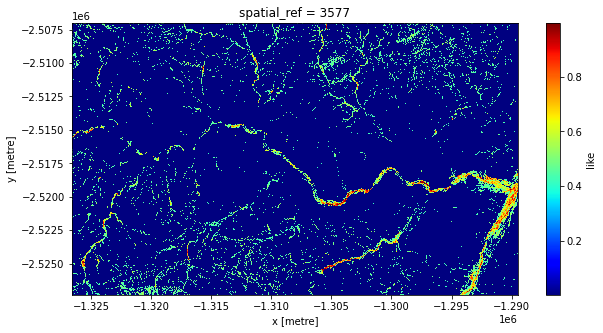

In [20]:
# perform thresholding using standard deviation on all-time median likelihood
ds_thresh = gdvspectra.threshold_likelihood(ds=ds_like.median('time', keep_attrs=True),
                                            df=df_records, 
                                            num_stdevs=2.5, 
                                            res_factor=3, 
                                            if_nodata='any')

# preview an all-time median of gdv likelihood thresholded
fig = plt.figure(figsize=(10, 5))
ds_thresh.where(~ds_thresh.isnull(), 0.001)['like'].plot(robust=False, cmap='jet')

### Export GDV likelihood and threshold for later

In [21]:
# export likelihood and thresholds   
#tools.export_xr_as_nc(ds_like, filename='ds_likelihood.nc')
#tools.export_xr_as_nc(ds_thresh, filename='ds_threshold.nc')

## Perform trend analysis

### Calculate trends using Mann-Kendall trend analysis

Performing Mann-Kendall test (original).


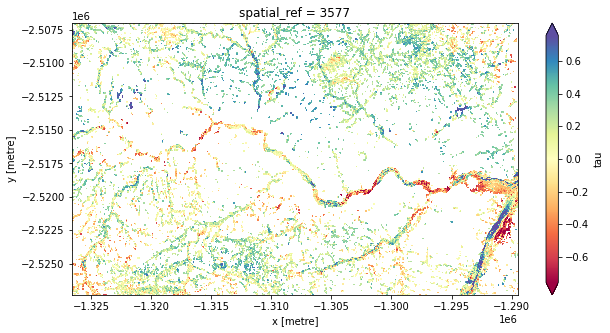

In [22]:
# create a mask where gdv highly likely
ds_mask = xr.where(~ds_thresh.isnull(), True, False)

# do mk to find sig. inc/dec trends in high likelihood areas
ds_mk = gdvspectra.perform_mk_original(ds=ds_like.where(ds_mask), 
                                       pvalue=None, 
                                       direction='both')

# show mk trends. blue is increasing, red is decreasing
fig = plt.figure(figsize=(10, 5))
ds_mk['tau'].plot(robust=True, cmap='Spectral')

### Calculate slope using Theil-Sen

Performing Theil-Sen slope (original).


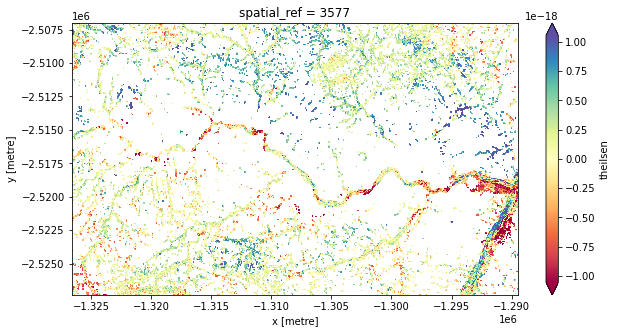

In [23]:
# create a mask where gdv highly likely
ds_mask = xr.where(~ds_thresh.isnull(), True, False)

# do theil sen slopes in high likelihood areas
ds_ts = gdvspectra.perform_theilsen_slope(ds=ds_like.where(ds_mask), 
                                          alpha=0.95)

# show mk trends. blue is increasing, red is decreasing
fig = plt.figure(figsize=(10, 5))
ds_ts['theilsen'].plot(robust=True, cmap='Spectral')

## Peform Change Vector Analysis (CVA)

### Get specific months from dataset copy

In [24]:
# set months in which to assess trend
trend_months = [9, 10, 11]

# subset months we want to assess across years during trend analysis
ds_cva = gdvspectra.subset_months(ds_backup, 
                                  month=trend_months)

# display dataset
#ds_cva

Subsetting down to specified months.
Reducing dataset into months: [9, 10, 11].
Subset to requested months successfully.


### Generate tasselled cap greenness and brightness

In [25]:
# calculate tasselled cap greenness and brightness indices
ds_cva = tools.calculate_indices(ds=ds_cva, 
                                 index=['tcg', 'tcb'],
                                 rescale=False, 
                                 drop=True)

# display dataset
#ds_cva

Calculating indices: ['tcg', 'tcb'].
Calculating index: tcg
Calculating index: tcb
Calculated indices successfully.


### Compute into memory

In [26]:
# resample median bug with dask, must have computed values
ds_cva = ds_cva.compute()

### Resample annual medians for selected dates

In [27]:
# reduce all selected months into annual medians (year starts, YS)
ds_cva = gdvspectra.resample_to_freq_medians(ds=ds_cva,
                                             freq='YS',
                                             inplace=True)

Resampling dataset down to annual medians.
Resampled down to annual medians successfully.


### Interpolate missing data

In [28]:
# interpolate all missing pixels using full linear interpolation
ds_cva = gdvspectra.interp_empty(ds=ds_cva,
                                 method='full',
                                 inplace=True)

# display dataset
#ds_cva

Interpolating empty values in dataset.
Interpolated empty values successfully.


### Standardise using invariant targets

In [29]:
# standardise to targets
ds_cva = gdvspectra.standardise_to_targets(ds_cva, 
                                           q_upper=0.99, 
                                           q_lower=0.05)

# display dataset
#ds_cva

Standardising data using invariant targets.
Calculating invariant target sites.
Got orthogonal polynomial coefficients: [-11.  -9.  -7.  -5.  -3.  -1.   1.   3.   5.   7.   9.  11.]
Got sum of squares: 572 and constant 2: 
Created invariant target sites successfully.
Standardising to invariant targets, rescaling via fuzzy sigmoidal.
Standardised using invariant targets successfully.


### Perform Change Vector Analysis

Performing CVA.
Doing CVA: 1.
Doing CVA: 2.
Doing CVA: 3.
Doing CVA: 4.
Doing CVA: 5.
Doing CVA: 6.
Performed CVA successfully.


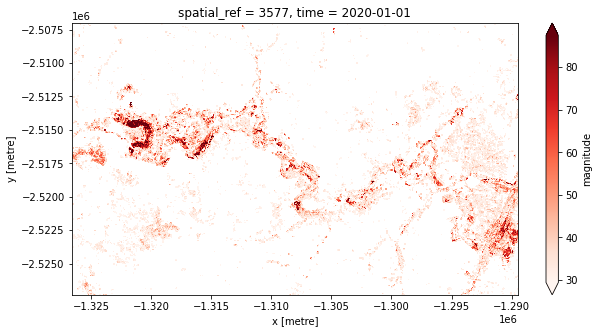

In [30]:
# set baseline date range. we will do just 2009
base_times = (2009, 2009)

# set comparison date range. we can compare each to baseline seperately
comp_times = (2015, 2020)

# generate cva
ds_cva_out = gdvspectra.perform_cva(ds=ds_cva,
                                    base_times=base_times,
                                    comp_times=comp_times,
                                    reduce_comp=False,
                                    vege_var = 'tcg',
                                    soil_var = 'tcb',
                                    tmf=2)

# plot magnitude of all change between 2009 and 2020
fig = plt.figure(figsize=(10, 5))
ds_cva_out['magnitude'].isel(time=-1).plot(robust=True, cmap='Reds')

### Isolate vegetation death change type

Isolating CVA angles from 90-180 degrees.
Isolated CVA angles successfully.


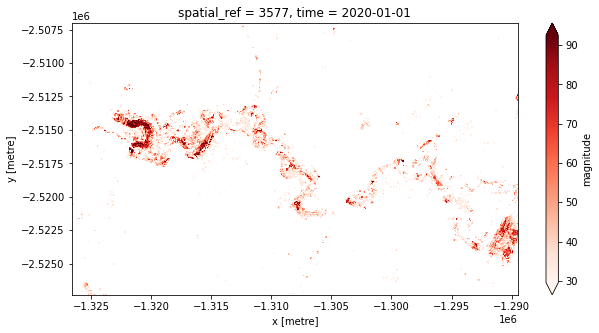

In [31]:
# isolate angles between 90-180 degrees to focus on veg decline only
ds_dec = gdvspectra.isolate_cva_change(ds_cva_out, angle_min=90, angle_max=180)

# plot magnitude for veg decline areas in 2020
fig = plt.figure(figsize=(10, 5))
ds_dec['magnitude'].isel(time=-1).plot(robust=True, cmap='Reds')

### Isolate vegetation growth change type

Isolating CVA angles from 270-360 degrees.
Isolated CVA angles successfully.


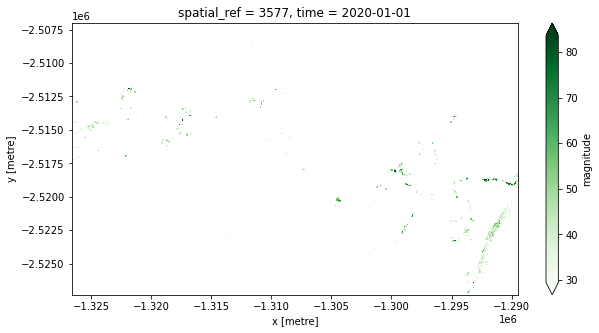

In [32]:
# isolate angles between 90-180 degrees to focus on veg decline only
ds_inc = gdvspectra.isolate_cva_change(ds_cva_out, angle_min=270, angle_max=360)

# plot magnitude for veg decline areas in 2020
fig = plt.figure(figsize=(10, 5))
ds_inc['magnitude'].isel(time=-1).plot(robust=True, cmap='Greens')

### Intersect veg decline with GDV likelihood areas

In [33]:
# warning this doesnt work.

# create a mask where gdv highly likely
ds_mask = xr.where(~ds_thresh.isnull(), True, False)

# select change areas where gdv exists for inc, dec
ds_inc = ds_inc.where(ds_mask)
ds_dec = ds_dec.where(ds_mask)

## Perform Break Point Detection on pixel

In [34]:
#pip install ruptures

### Calculate tasselled cap greenness

In [35]:
# calculate tasselled cap greenness and brightness indices
ds_breaks = tools.calculate_indices(ds=ds_backup, index=['tcg'], rescale=False, drop=True)

# display dataset
#ds_breaks

Calculating indices: ['tcg'].
Calculating index: tcg
Calculated indices successfully.


### Resample monthly medians for each year

In [36]:
# reduce all selected months into monthly medians
ds_breaks = gdvspectra.resample_to_freq_medians(ds=ds_breaks,
                                                freq='1MS',
                                                inplace=True)

# display dataset
#ds_breaks

Resampling dataset down to annual medians.
Resampled down to annual medians successfully.


### Interpolate empty months along month axis

In [37]:
# interpolate empty values along monthly dimension
ds_breaks = gdvspectra.interp_empty_months(ds=ds_breaks, 
                                           method='full',
                                           inplace=True)

# display dataset
#ds_breaks

Interpolating empty values along months in dataset.
Interpolating along month: 1
Interpolating along month: 2
Interpolating along month: 3
Interpolating along month: 4
Interpolating along month: 5
Interpolating along month: 6
Interpolating along month: 7
Interpolating along month: 8
Interpolating along month: 9
Interpolating along month: 10
Interpolating along month: 11
Interpolating along month: 12
Interpolating empty values along months successfully.


### Compute into memory

In [38]:
# we need values, do a final compute
ds_breaks = ds_breaks.compute()

### Detect breaks for selected pixels (to implement in ArcGIS)

In [ ]:
%autoreload
# take x, y from clicked pixel in arcgis
x, y = -1322085.0, -2514525.0

# get values, dates
da = ds_breaks.sel(x=x, y=y, method='nearest', tolerance=50)
values, times = np.array(da['tcg']), np.array(da['time'])

# detect_breaks(values, times, pen=3)
break_times = gdvspectra.detect_breaks(values=values, 
                                       times=times, 
                                       pen=3, 
                                       fill_nan=True, 
                                       quick_plot=True)

# display dataset
#break_times